In [171]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
# import nilearn"

In [172]:
data = pd.read_csv('noraml_results.csv',low_memory=False)
data = data.set_index(['SubjectID'])
y = pd.read_csv('train_labels_MGMT.csv')
y = y.set_index(['BraTS21ID'])

# ids = data['SubjectID']
y.shape

(585, 1)

In [173]:
# data = data.drop(['SubjectID'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208 entries, 0 to 1666
Columns: 545 entries, FLAIR_ED_Intensity_CoefficientOfVariation to T2_ED_LBP_Radius-1_Bins-20_LBP
dtypes: float64(334), int64(135), object(76)
memory usage: 5.0+ MB


In [174]:

# np.sum(data_numeric['FLAIR_ED_Intensity_CoefficientOfVariation'].astype(float).isnull())
data_numeric = data.apply(pd.to_numeric,errors='coerce')
data_na = data_numeric[data_numeric.isna().any(axis=1)]

# data_na.drop([293,743,904],axis=0)
data_na





,FLAIR_ED_Intensity_CoefficientOfVariation,FLAIR_ED_Intensity_Energy,FLAIR_ED_Intensity_InterQuartileRange,FLAIR_ED_Intensity_Kurtosis,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_Mean,FLAIR_ED_Intensity_MeanAbsoluteDeviation,FLAIR_ED_Intensity_Median,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,...,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeMean,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNonUniformity,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNoneUniformityNormalized,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeVariance,T2_ED_NGTDM_Busyness,T2_ED_NGTDM_Coarsness,T2_ED_NGTDM_Complexity,T2_ED_NGTDM_Contrast,T2_ED_NGTDM_Strength,T2_ED_LBP_Radius-1_Bins-20_LBP
SubjectID,,,,,,,,,,,,,,,,,,,,,
14,0.144956,4.546696e+04,30.747772,0.250000,165.364304,149.990418,0.000000e+00,149.990418,0.000000,134.616531,...,1.000000,2.000000,1.000000,0.000000,0.552632,0.095238,199.500000,947.625000,34.380952,30.064860
140,0.030319,1.500581e+06,6.000000,2.807781,170.538467,158.073077,-5.684342e-15,157.730774,0.342303,147.692307,...,1.132075,42.169811,0.795657,0.152367,0.253918,0.024048,1523.005645,1.244576,3.517641,863.496703
258,0.163524,6.730304e+04,18.422050,1.270947,142.205322,114.798476,-5.684342e-15,109.239540,5.558936,93.403038,...,1.250000,2.500000,0.625000,0.187500,0.500000,0.063291,319.466667,67.466667,12.007273,70.456887
338,0.014886,1.571243e+05,4.467148,1.066010,164.540146,161.810219,0.000000e+00,161.934311,-0.124092,158.583939,...,1.200000,3.400000,0.680000,0.160000,0.380952,0.093750,317.888889,29.948148,14.346154,90.171584
425,NaN,2.377845e+03,0.000000,NaN,48.763157,48.763157,0.000000e+00,48.763157,0.000000,48.763157,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
444,0.087228,5.655807e+04,7.083336,1.831951,91.901711,79.006412,3.157968e-15,75.918808,3.087604,71.378204,...,1.000000,9.000000,1.000000,0.000000,0.379397,0.059603,456.566667,28.498765,13.892720,135.282465
1180,NaN,1.272891e+04,0.000000,NaN,112.822472,112.822472,0.000000e+00,112.822472,0.000000,112.822472,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
1344,NaN,3.459157e+04,0.000000,NaN,185.988098,185.988098,0.000000e+00,185.988098,0.000000,185.988098,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
1568,0.106352,2.146930e+05,15.738022,2.803975,199.955627,163.014196,0.000000e+00,160.067993,2.946203,145.281250,...,1.000000,8.000000,1.000000,0.000000,0.309524,0.102564,321.500000,17.375000,15.200000,120.201633


In [175]:
data_clean = data_numeric.dropna()
data_clean.shape

(1199, 545)

In [176]:
indices = np.intersect1d(data_clean.index.values , y.index.values)
labeled_data = data_clean.loc[indices]
y = y.loc[indices]
labeled_data.shape

(555, 545)

In [177]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(data_clean)
X_pca.shape

(1199, 100)

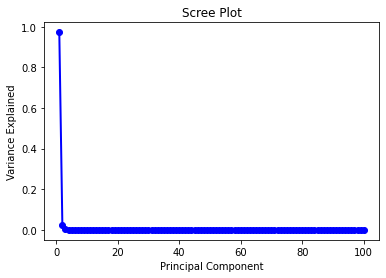

In [178]:
import matplotlib.pyplot as plt
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [179]:
from sklearn.metrics import mean_squared_error
X_pred = pca.inverse_transform(X_pca)
mean_squared_error(data_clean,X_pred)

994.8191863714281

In [180]:
data_clean.shape

(1199, 545)

In [181]:
from sklearn.decomposition import KernelPCA
kPca = KernelPCA(n_components=10,kernel='poly')
X_kpca = kPca.fit_transform(data_clean)
X_kpca.shape

(1199, 10)

In [182]:
labeled_pca = pca.transform(labeled_data)
labeled_pca = pd.DataFrame(labeled_pca,index=indices)

In [183]:
labeled_pca.shape

(555, 100)

In [184]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=20)
X_fa = fa.fit_transform(data_clean)
X_fa.shape

(1199, 20)

In [185]:
labeled_fa = fa.transform(labeled_data)
labeled_fa = pd.DataFrame(labeled_fa,index=indices)


In [186]:
labeled_combined = labeled_pca.join(other=labeled_fa,lsuffix='_pca',rsuffix='_fa')
labeled_combined.columns = labeled_combined.columns.astype(str)
# labeled_combined = pd.DataFrame(labeled_combined)
labeled_combined.shape

(555, 120)

In [187]:
temp = np.ravel(y)
temp.shape

(555,)

In [188]:
from sklearn.feature_selection import r_regression
pear = r_regression(labeled_pca,temp)
pear = pd.DataFrame(pear)
pear_clean = pear[~pear.isin([np.nan, np.inf, -np.inf]).any(1)]

In [189]:
pear_clean.describe()

,0
count,100.000000
mean,-0.000260
std,0.043787
min,-0.097323
25%,-0.029685
50%,0.004053
75%,0.033419
max,0.089093


In [190]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100)
rnd_clf.fit(labeled_combined,temp)

RandomForestClassifier()

In [191]:
feat_importances = pd.Series(rnd_clf.feature_importances_, index=np.arange(labeled_combined.shape[1]))
# feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [192]:
from sklearn.feature_selection import RFE
selector_rfe = RFE(estimator=rnd_clf,n_features_to_select=30,step=1).fit(labeled_combined,temp)

In [193]:
ranking_rfe = np.argpartition(selector_rfe.ranking_,30)[:30]
ranking_rfe

array([ 21,  73,  68,  65,  78,  60,   1,  56,  53,  52, 119,  80,  45,
        44,  87,  29,  28,  27,  26,  25,  74,  99, 118,  97,  95,  20,
        14,  98,  91,  13])

In [194]:
selector_rfe.ranking_

array([86,  1, 89, 58, 70, 56, 65, 30, 42, 61, 83, 63, 48,  1,  1, 64, 90,
       39, 50, 62,  1,  1, 35, 14, 84,  1,  1,  1,  1,  1, 36,  9, 33, 78,
       87, 85, 79, 22, 49, 72, 60, 77, 47, 21,  1,  1, 67, 12,  4, 59, 45,
       16,  1,  1, 71, 34,  1, 23,  3, 75,  1, 57, 53, 17, 68,  1, 20, 73,
        1, 43, 29, 15, 11,  1,  1, 37,  5, 41,  1, 24,  1,  7, 25,  6, 66,
       10, 13,  1, 54,  8, 51,  1, 26, 38, 18,  1, 19,  1,  1,  1, 74, 44,
       80, 82, 76, 55, 46, 28, 88, 40, 31, 27, 91, 52,  2, 32, 69, 81,  1,
        1])

In [195]:
from sklearn.feature_selection import RFECV

selector_rfecv = RFECV(rnd_clf,n_jobs=-1).fit(labeled_combined,temp)

In [196]:
selector_rfecv.ranking_

array([39,  1, 11,  1, 34, 32,  1,  1,  1,  1, 35, 20, 22,  1,  1, 21, 29,
        1, 26,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  9,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, 18,  1,  1,  7,  1,  1, 14,  1,
        1,  1,  1, 16, 17,  1, 15, 30,  1,  1,  1,  1,  1,  1,  1,  1, 10,
        1,  1,  1,  1,  1,  1,  1,  1,  1, 12,  1,  1,  1,  1,  2,  1,  4,
        1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1, 28,  1,
       25, 24,  1, 31, 27, 13, 33, 38, 37, 19, 23,  8,  1,  1,  6, 36,  1,
        1])

In [197]:
ranking_rfecv = np.argpartition(selector_rfecv.ranking_,30)[:30]
ranking_rfecv

array([ 79,  80,  52,  53,  56,   1,  60,  61,  62,  63,  64,  65,  66,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  50, 101, 104,
        97,  98,  99,  95])

In [198]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(rnd_clf,n_features_to_select=30,n_jobs=-1)
sfs.fit(labeled_combined,temp)

In [ ]:
ranking_sfs = sfs.get_support(indices=True)
ranking_sfs

array([ 13,  14,  18,  19,  21,  28,  29,  32,  36,  44,  45,  49,  54,
        58,  71,  75,  76,  88,  94,  95,  98,  99, 100, 103, 105, 106,
       108, 111, 114, 118])

In [ ]:
from sklearn.feature_selection import f_classif
anova = f_classif(labeled_combined,temp)

In [ ]:
ranking_anova= np.argpartition(anova[0],-30)[-30:]
ranking_anova

array([ 83,  47, 107,  84,  93,   0,  74,  79,  25,  99,  98, 101, 102,
        80,   1,  26,  60,  95,  14,  65,  29,  35,  68,  32, 114, 115,
        48,   3,   2, 103])

In [ ]:
from sklearn.feature_selection import mutual_info_classif
selector_mutual = mutual_info_classif(labeled_combined,temp)

In [ ]:
ranking_mut = np.argpartition(selector_mutual,-30)[-30:]
ranking_mut

array([ 69,  61,   6,  13,   1, 109,  26,  97,  98, 113,  81,  56,  33,
       118,  76,  51,  95,  54, 100,  72,  92,  85, 112,  64,  66,  34,
       116,  67,  20,  70])

In [ ]:
intersect = ranking_rfe
rankings = [ranking_rfe,ranking_rfecv,ranking_sfs,ranking_anova,ranking_mut]
for rank in rankings:
    intersect = np.intersect1d(rank,intersect)

In [ ]:
intersect

array([95, 98])

In [ ]:
feat, count = np.unique(rankings,return_counts=True)
feat,count

(array([  0,   1,   2,   3,   6,  13,  14,  18,  19,  20,  21,  24,  25,
         26,  27,  28,  29,  32,  33,  34,  35,  36,  44,  45,  47,  48,
         49,  51,  52,  53,  54,  56,  58,  60,  61,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  79,  80,  81,  82,
         83,  84,  85,  87,  88,  89,  92,  93,  94,  95,  97,  98,  99,
        100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114,
        115, 116, 118, 119]),
 array([1, 3, 1, 1, 1, 4, 4, 1, 1, 3, 2, 1, 3, 4, 2, 1, 4, 2, 1, 1, 3, 1,
        3, 3, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 1, 1, 3,
        1, 3, 2, 2, 1, 3, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 5, 2, 5, 4, 2,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1]))

In [ ]:
freq_array = np.asarray((feat,count)).T
freq_array

array([[  0,   1],
       [  1,   3],
       [  2,   1],
       [  3,   1],
       [  6,   1],
       [ 13,   4],
       [ 14,   4],
       [ 18,   1],
       [ 19,   1],
       [ 20,   3],
       [ 21,   2],
       [ 24,   1],
       [ 25,   3],
       [ 26,   4],
       [ 27,   2],
       [ 28,   1],
       [ 29,   4],
       [ 32,   2],
       [ 33,   1],
       [ 34,   1],
       [ 35,   3],
       [ 36,   1],
       [ 44,   3],
       [ 45,   3],
       [ 47,   1],
       [ 48,   2],
       [ 49,   1],
       [ 51,   1],
       [ 52,   2],
       [ 53,   2],
       [ 54,   2],
       [ 56,   1],
       [ 58,   1],
       [ 60,   2],
       [ 61,   1],
       [ 64,   2],
       [ 65,   3],
       [ 66,   1],
       [ 67,   1],
       [ 68,   2],
       [ 69,   1],
       [ 70,   1],
       [ 71,   1],
       [ 72,   3],
       [ 73,   1],
       [ 74,   3],
       [ 75,   2],
       [ 76,   2],
       [ 79,   1],
       [ 80,   3],
       [ 81,   3],
       [ 82,   2],
       [ 83,

In [ ]:
sort_freq = freq_array[freq_array[:, 1].argsort()[::-1]]
final_features = sort_freq[:20][:,0]
final_features

array([95, 98, 13, 99, 26, 14, 29, 74, 25, 20, 45, 44, 83, 80, 35, 81,  1,
       72, 65, 75])

In [ ]:
labeled_combined

,0_pca,1_pca,2_pca,3_pca,4_pca,5_pca,6_pca,7_pca,8_pca,9_pca,...,10_fa,11_fa,12_fa,13_fa,14_fa,15_fa,16_fa,17_fa,18_fa,19_fa
0,-8.506203e+07,-1.642656e+08,-2.124766e+07,-1.516393e+07,-1.025007e+07,-3.062886e+06,-3.281933e+06,5.100273e+05,-4.055506e+05,-5.574672e+04,...,-0.612262,0.216482,-0.138882,-0.176308,-0.701571,-0.085686,0.151488,0.019310,-0.420419,-0.182707
2,-7.692812e+06,-1.885094e+08,-4.925806e+07,-1.327803e+07,-7.380151e+06,-2.529281e+06,-7.219787e+06,4.088869e+05,-1.548797e+04,6.780401e+05,...,0.871743,-0.744695,-0.502159,-0.118526,-0.161174,1.465606,-0.998582,0.626828,-0.368809,-0.277251
3,2.678155e+08,-2.947000e+08,-1.126429e+08,-1.442832e+07,1.542603e+05,-1.259507e+07,-5.302600e+06,1.339938e+05,3.440698e+05,-2.951149e+05,...,-0.646027,-0.388548,-0.464059,0.132873,-0.834913,0.795587,-0.511371,-0.272675,-0.350974,-0.542322
5,7.524405e+08,-5.820749e+06,-1.576167e+08,-2.997054e+07,-1.051068e+07,4.337707e+06,-1.713572e+06,-5.013792e+05,1.326157e+06,-2.164233e+06,...,-1.187536,0.853703,-0.786992,1.636747,1.153656,2.724628,0.119753,-0.359019,-1.047772,5.186829
6,1.841889e+09,-5.051876e+08,-9.915082e+07,-4.167806e+07,-4.310442e+07,2.358284e+07,5.909868e+07,-3.748935e+06,-1.064539e+05,-1.935440e+06,...,-1.583372,-1.208105,0.320217,0.604029,-1.940073,0.225540,-0.449621,2.058586,-0.592966,0.621984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,-6.812900e+08,1.907166e+07,3.105493e+06,1.490384e+07,8.706529e+06,-1.038744e+05,-3.237581e+06,-5.238958e+05,-7.453645e+04,7.194676e+05,...,0.865916,-0.195982,0.108929,-0.386578,0.699614,0.227721,-0.275503,0.145151,-0.722456,-0.097781
1007,-4.629018e+07,-2.345749e+07,2.508646e+07,-5.083799e+06,1.166242e+07,-7.162299e+06,4.181757e+05,-1.125166e+06,-8.540356e+05,-5.784066e+04,...,0.095720,-0.291508,0.023626,-0.215328,0.083972,-0.216776,0.188353,0.263739,-0.324159,-0.428315
1008,-9.581541e+08,-1.570254e+07,-4.948755e+06,1.707869e+07,-4.339612e+06,3.264582e+06,7.795172e+05,-2.635684e+05,-5.142584e+05,2.503140e+04,...,-0.046974,0.017552,-0.017269,0.128027,-0.071856,0.004470,-0.036286,-0.003193,-0.158769,0.416665
1009,-3.116108e+08,1.028817e+07,4.604474e+07,-3.442275e+06,7.970484e+05,-1.144992e+05,1.641268e+06,-2.608463e+05,-7.935704e+05,-7.975836e+04,...,-0.189641,-0.186338,0.054453,0.080506,0.234165,-0.152924,0.264231,-0.102989,-0.437089,0.115913


In [ ]:
train_out = labeled_combined.iloc[:,final_features]
train_out.head()

,95,98,13_pca,99,26,14_pca,29,74,25,20,45,44,83,80,35,81,1_pca,72,65,75
0,-255.420130,144.663200,4825.086600,-19.277827,3092.044888,-89961.381625,-983.895802,6.659341,-25308.919005,19173.492616,-1807.215352,-1271.207623,102.417978,-64.650687,-1974.229165,-102.409113,-1.642656e+08,-305.269507,109.937539,-568.295252
2,-514.567024,-220.288160,-5418.507205,-261.553322,55228.566134,-84042.035557,3090.433378,-504.804531,-22704.272327,-21046.221482,1205.303070,-1759.969911,112.163312,-564.890690,-10337.102356,-120.203962,-1.885094e+08,248.226919,-999.605389,-263.862968
3,108.191666,154.462961,72453.355111,15.738291,9752.151900,-142267.774077,-12204.786543,-395.202993,-14195.051220,40974.769082,-1072.398721,-934.107379,-0.807152,-41.330871,-3422.346499,688.567490,-2.947000e+08,489.677606,125.784118,-375.817895
5,-809.595747,488.266218,157272.811573,276.571799,984.686651,213097.231290,-24774.751241,-426.919780,-29676.494020,-99716.828906,-625.136424,-840.963545,803.874476,120.274964,-17254.624701,1508.024324,-5.820749e+06,1376.381095,2979.426793,-1444.396315
6,-53.620813,-306.918230,138654.640305,161.679681,-13162.842636,-133114.112442,-12298.610161,-496.648834,-5981.016899,32411.009637,-1824.846265,-1345.979361,56.503937,36.912764,1822.655578,291.497495,-5.051876e+08,-119.296194,-665.111755,167.478261


In [ ]:
train_out.shape

(555, 20)